# Final Project — DX703 — Fall 2025 — Team 22

**Team Members:**  
- James Kantor  
- Khurram Khan  
- Surendra Koththigoda  

**Date Submitted:** December 7, 2025  

**Notebook Purpose:**  
This notebook presents the implementation of our final Food-101 classification pipeline. It loads and preprocesses the dataset, applies our finalized augmentation and normalization steps, and trains and evaluates our best-performing convolutional neural network model to classify images into 101 food categories.

**Dataset:** Food-101 (101 food categories; ~1000 images per class)


## A.1: Setup and Context


## Summary of Milestones 1 and 2
During Milestones 1 and 2, we built a complete preprocessing workflow and pipeline for the Food-101 dataset and experimented with model architectures to increase model results.

### Data Cleaning and Preprocessing:
The dataset used was HuggingFace's Food-101 repository - a well-known image classification dataset. This dataset provides clean labels and useful metadata. Because no label or metadata cleaning was required, we focused our efforts on preparing the raw images for model input and did not need to clean labels or metadata. To process, we converted each image to RGB, resized to a uniform 160×160 resolution, normalized to the range 0–1, and serialized into TFRecords for reproducibility and consistent ordering. We didn't find duplicate or damaged images, however during training we did find one image corruption.

### Feature Engineering and Augmentation:
Our preprocessing pipeline performed the following:

* RGB conversion to handle channel formatting

* Resizing to 160×160 to reduce compute cost while preserving enough structure for CNN classification

* Normalization to 0–1 for stable gradient updates

* Light augmentation (horizontal flips applied only to the training split) to improve robustness without altering the validation/test distributions

* Batching & prefetching (batch size = 32, AUTOTUNE) to maximize GPU utilization

Because Food-101 is balanced across its 101 classes as its title indicates, we did not need to address any class imbalance techniques. Augmentation served as the primary method for improving generalization.

### Early Model Experiments (Milestone 2) and Key Findings:
In Milestone 2, we iterated on various models from a CNN baseline model to customized versions. We used a pretrained model, MobileNetV2, for our best results. We learned the following:

* Simple CNN baselines underfit without sufficient depth or regularization.

* Dropout and batch normalization significantly improved stability, especially in deeper models.

* Data augmentation was essential and models trained without it overfit rapidly.

* Validation accuracy was sensitive to learning-rate scheduling, and AdamW with a moderate LR provided the best convergence.

We used these concepts to design our final model: controlled depth, dropout, normalization, and the augmentation strategies that proved most effective in our Milestone 2 experiments.

## Final Preprocessing Pipeline

Our preprocessing pipeline is divided into the following cells:
* Imports & Setup
* Build Records
* Load Datasets
* Training Utilities

### Imports & Setup

This cell loads the pipeline's utilities. This includes all major libraries and PyTorch It also sets mixed precision, a GPU optimization technique we discovered. This cell also sets the processing device to be the local GPU, and, if not present, selects CPU.  Finally, the cell sets the global parameters like seed, batch size, and target image size for the preprocessing.

In [2]:
# ============================================================
# Imports & Setup (PyTorch Version)
# ============================================================

import os, time, math, random, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Mixed precision for CUDA
from torch.cuda.amp import autocast, GradScaler

# Enable TF32 for faster training
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Random seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Time formatting
def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# ------------------------------------------------------------
# Global Image Processing Config
# ------------------------------------------------------------

IMG_SIZE = 160
BATCH_SIZE = 32

print(f"All utilities loaded")

Using device: cuda
All utilities loaded


## Build TF Records

This cell loads the data - either from the HuggingFace repository or locally cached preprocessed files. It also loads file utilities and splits the data into needed test/train/validation sets.


Image and File helper utilites: These functions help the image processing and file handling of the pipeline.

Splits and Write: This code processes the splits and writes the records.


In [4]:
# ============================================================
# Data Preparation - No Caching
# ============================================================

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Food101Dataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']
        
        # Convert to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load dataset
print("Loading Food-101 dataset...")
food_all = load_dataset("food101", split="train+validation")

# Remove corrupted images
corrupted_indices = [30105, 79553, 84579]
print(f"Original dataset size: {len(food_all):,}")

valid_indices = [i for i in range(len(food_all)) if i not in corrupted_indices]
food_all = food_all.select(valid_indices)

print(f"Cleaned dataset size: {len(food_all):,}")
print(f"Removed {len(corrupted_indices)} corrupted images")

# Split dataset
labels = np.array(food_all["label"])
idx_all = np.arange(len(food_all))

train_idx, temp_idx = train_test_split(
    idx_all, test_size=0.2, stratify=labels, random_state=SEED
)

temp_labels = labels[temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=SEED
)

# Create datasets
train_data = food_all.select(train_idx.tolist())
val_data = food_all.select(val_idx.tolist())
test_data = food_all.select(test_idx.tolist())

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = Food101Dataset(train_data, train_transform)
val_dataset = Food101Dataset(val_data, val_transform)
test_dataset = Food101Dataset(test_data, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders ready")

Loading Food-101 dataset...
Original dataset size: 101,000
Cleaned dataset size: 100,997
Removed 3 corrupted images
Train: 80797, Val: 10100, Test: 10100
DataLoaders ready


In [5]:
import warnings

print("Scanning for truncated/corrupted images...")
print(f"Total images: {len(food_all):,}\n")

corrupted_indices = []

for idx in range(len(food_all)):
    # Suppress warnings temporarily so we can catch them
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        
        try:
            # This is where the truncation happens
            item = food_all[idx]
            image = item['image']
            
            # Check if any "Truncated" warnings were raised
            truncated_warnings = [warning for warning in w if "Truncated" in str(warning.message)]
            
            if truncated_warnings:
                corrupted_indices.append(idx)
                print(f"Index {idx}: Truncated File Read")
                
        except Exception as e:
            # Catch any other errors
            if "Truncated" not in str(e):
                corrupted_indices.append(idx)
                print(f"Index {idx}: {str(e)[:50]}")
    
    # Progress indicator
    if (idx + 1) % 10000 == 0:
        print(f"Progress: {idx + 1:,}/{len(food_all):,}")

print("\n" + "="*60)
print("Scan Complete")
print("="*60)
print(f"Total images scanned: {len(food_all):,}")
print(f"Truncated images found: {len(corrupted_indices)}")
print(f"Corruption rate: {len(corrupted_indices)/len(food_all)*100:.4f}%")

if corrupted_indices:
    print(f"\nFirst 20 corrupted indices: {corrupted_indices[:20]}")
    
    # Distribution across splits
    corrupted_in_train = [idx for idx in corrupted_indices if idx in train_idx]
    corrupted_in_val = [idx for idx in corrupted_indices if idx in val_idx]
    corrupted_in_test = [idx for idx in corrupted_indices if idx in test_idx]
    
    print(f"\nDistribution:")
    print(f"  Train set: {len(corrupted_in_train)}/{len(train_idx)} ({len(corrupted_in_train)/len(train_idx)*100:.2f}%)")
    print(f"  Val set: {len(corrupted_in_val)}/{len(val_idx)} ({len(corrupted_in_val)/len(val_idx)*100:.2f}%)")
    print(f"  Test set: {len(corrupted_in_test)}/{len(test_idx)} ({len(corrupted_in_test)/len(test_idx)*100:.2f}%)")

Scanning for truncated/corrupted images...
Total images: 100,997

Progress: 10,000/100,997
Progress: 20,000/100,997
Progress: 30,000/100,997
Progress: 40,000/100,997
Progress: 50,000/100,997
Progress: 60,000/100,997
Progress: 70,000/100,997
Progress: 80,000/100,997
Progress: 90,000/100,997
Progress: 100,000/100,997

Scan Complete
Total images scanned: 100,997
Truncated images found: 0
Corruption rate: 0.0000%


This cell validates the stratification and confirms class balance cross datasets for train, test, validation.


In [4]:

# Get labels for each split
train_labels = labels[train_idx]
val_labels = labels[val_idx]
test_labels = labels[test_idx]

# Overall statistics
print("="*60)
print("Split Distribution Summary")
print("="*60)

print(f"\nTotal samples: {len(labels):,}")
print(f"Number of classes: {len(np.unique(labels))}")
print(f"\nSplit sizes:")
print(f"  Train:      {len(train_labels):,} samples ({len(train_labels)/len(labels)*100:.1f}%)")
print(f"  Validation: {len(val_labels):,} samples ({len(val_labels)/len(labels)*100:.1f}%)")
print(f"  Test:       {len(test_labels):,} samples ({len(test_labels)/len(labels)*100:.1f}%)")

# Check if perfectly balanced
print("\n" + "="*60)
print("Class Balance Check")
print("="*60)

train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)
test_counts = np.bincount(test_labels)

# Check if all classes have same count
train_perfect = len(np.unique(train_counts)) == 1
val_perfect = len(np.unique(val_counts)) == 1
test_perfect = len(np.unique(test_counts)) == 1

print(f"\nTrain set: {'balanced' if train_perfect else 'imbalanced'}")
print(f"  {train_counts[0]} samples per class (all {len(train_counts)} classes)")

print(f"\nValidation set: {'balanced' if val_perfect else 'imbalanced'}")
print(f"  {val_counts[0]} samples per class (all {len(val_counts)} classes)")

print(f"\nTest set: {'balanced' if test_perfect else 'imbalanced'}")
print(f"  {test_counts[0]} samples per class (all {len(test_counts)} classes)")

# Verify stratification worked
print("\n" + "="*60)
print("Stratification Verification")
print("="*60)

print(f"\nOriginal dataset had {len(labels)//len(np.unique(labels))} samples per class")
print(f"\nAfter split:")
print(f"  Train:      {train_counts[0]} samples per class")
print(f"  Validation: {val_counts[0]} samples per class")
print(f"  Test:       {test_counts[0]} samples per class")
print(f"  Total:      {train_counts[0] + val_counts[0] + test_counts[0]} samples per class")

# Show a few example classes
print("\n" + "="*60)
print("Sample of Classes (First 5)")
print("="*60)
print(f"\n{'Class Name':<25} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
print("-"*70)

class_names = food_all.features['label'].names

for i in range(min(5, len(train_counts))):
# Get class name or use index
    if class_names is not None:
        name = class_names[i]
    else:
        name = f"Class {i}"
    
    total = train_counts[i] + val_counts[i] + test_counts[i]
    print(f"{name:<25} {train_counts[i]:<10} {val_counts[i]:<10} {test_counts[i]:<10} {total:<10}")

print("\n" + "="*60)

Split Distribution Summary

Total samples: 100,997
Number of classes: 101

Split sizes:
  Train:      80,797 samples (80.0%)
  Validation: 10,100 samples (10.0%)
  Test:       10,100 samples (10.0%)

Class Balance Check

Train set: imbalanced
  799 samples per class (all 101 classes)

Validation set: balanced
  100 samples per class (all 101 classes)

Test set: balanced
  100 samples per class (all 101 classes)

Stratification Verification

Original dataset had 999 samples per class

After split:
  Train:      799 samples per class
  Validation: 100 samples per class
  Test:       100 samples per class
  Total:      999 samples per class

Sample of Classes (First 5)

Class Name                Train      Val        Test       Total     
----------------------------------------------------------------------
apple_pie                 799        100        100        999       
baby_back_ribs            800        100        100        1000      
baklava                   800        100   

## Load TF Record Datasets

This cell builds the TFRecord input pipeline. It defines a parser that decodes each serialized example, reshapes the image to the image size global parameter, and casts labels for training.

The code loads each split’s TFrecord file, maps records through the parser, optionally shuffles and applies simple augmentation (random horizontal flip for training), and batches/prefetches using Autotune for performance.

The train/val/test datasets are then created, a sample batch is inspected to confirm shapes and labels, and the pipeline indicates that the datasets are ready for training.


In [6]:
# ============================================================
# Verify DataLoaders
# ============================================================

# Note: This verification can fail with too many workers defined above if there is contention with shared system memory. 
# Set num_workers to 2 instead of 4 to stop errors. Values could be 0 (slowest), 2 (balanced), or 4 (speed)

# Check one batch to verify shapes and labels
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")  # Should be [32, 3, 160, 160]
    print(f"Labels shape: {labels.shape}") # Should be [32]
    print(f"First 5 labels: {labels[:5]}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    break

print("\nDataLoaders ready for training.")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch shape: torch.Size([32, 3, 160, 160])
Labels shape: torch.Size([32])
First 5 labels: tensor([20, 70, 31, 47, 94])
Image range: [-2.118, 2.640]

DataLoaders ready for training.
Train batches: 2525
Val batches: 316
Test batches: 316


## Training Utilities

This cell provides reusable training and evaluation helpers used throughout the project. The code is directly from our courseware.

### Learning Curve Visualization  
This function takes a Keras training history and generates side-by-side plots of training vs. validation loss and accuracy.  
It highlights the epoch with the lowest validation loss, prints final metrics, and records the validation accuracy.

### Training Wrapper  
This function executes the training workflow: it compiles the model, applies optional EarlyStopping, runs training with validation tracking, plots results, evaluates on the test set, and saves key metrics to results.


In [7]:
# ============================================================
# Training Utilities (PyTorch Version)
# ============================================================

from torch.amp import autocast, GradScaler

# Set up results data
results = {}

def plot_learning_curves(history, title, verbose=True, save_path=None, track_results=True):
    """Plot training curves from PyTorch training history"""
    val_losses = history.get('val_loss')
    val_accuracies = history.get('val_acc')
    train_losses = history.get('train_loss')
    train_accuracies = history.get('train_acc')
    
    if val_losses is None or train_losses is None:
        raise ValueError("Missing 'train_loss' or 'val_loss' in history.")

    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = val_accuracies[min_val_epoch] if val_accuracies else None

    epochs = range(1, len(val_losses) + 1)
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    axs[0].plot(epochs, train_losses, label='Train Loss')
    axs[0].plot(epochs, val_losses, label='Val Loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', s=50)
    axs[0].set_title(f'{title} - Loss')
    axs[0].legend()
    axs[0].grid(True)

    if train_accuracies and val_accuracies:
        axs[1].plot(epochs, train_accuracies, label='Train Acc')
        axs[1].plot(epochs, val_accuracies, label='Val Acc')
        axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', s=50)
        axs[1].set_title(f'{title} - Accuracy')
        axs[1].set_ylim(0, 1.05)
        axs[1].legend()
        axs[1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

    if verbose:
        print(f"Final Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
        print(f"Val Acc @ Min Loss (epoch {min_val_epoch+1}): {val_acc_at_min_loss:.4f}")

    if track_results and val_acc_at_min_loss is not None:
        results[title] = (val_acc_at_min_loss, min_val_epoch + 1)


def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_and_test(model,
                   train_loader, val_loader, test_loader,
                   epochs=50,
                   learning_rate=1e-3,
                   weight_decay=1e-4,
                   title="Learning Curves",
                   use_early_stopping=True,
                   patience=10,
                   min_delta=0.0001,
                   verbose=1,
                   return_history=False):

    
    print(f"\n{title}\n")
    print(f"Model: {model.__class__.__name__}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Move model to device
    model = model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7, verbose=True
    )
    
    # Mixed precision scaler
    scaler = GradScaler('cuda')
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    
    # Training loop
    start_time = time.time()
    
    for epoch in range(epochs):
        if verbose >= 1:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print("-" * 50)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Print epoch summary
        if verbose >= 1:
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"Learning Rate: {current_lr:.2e}")
        
        # Save best model
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            if verbose >= 1:
                print(f"New best model! Val Acc: {val_acc:.4f}")
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if use_early_stopping and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
    
    total_time = time.time() - start_time
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Plot learning curves
    plot_learning_curves(history, title, verbose=(verbose >= 1))
    
    # Evaluate on test set
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | ΔVal-Test: {abs(best_val_acc - test_acc):.4f}")
    print(f"Execution Time: {format_hms(total_time)}")
    
    # Save results
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    results[title] = {
        "val_acc_at_min_loss": best_val_acc,
        "min_val_epoch": best_epoch + 1,
        "test_acc": test_acc,
        "test_loss": test_loss,
    }
    
    if return_history:
        return history
    
    return model

print(" Training utilities loaded")

 Training utilities loaded


## A.2: Model Selection and Retraining


### **Model Architecture and Rationale**
Based on our experiments, our best-performing model is a pretrained MobileNetV2 architecture with the classification head unfrozen.  We removed the original classifier (include_top = False), applied global average pooling, and added a dense layer for Food-101 classification.

**Why MobileNetV2?**
- Efficient and fast on Colab GPUs  
- Strong transfer-learning performance  
- Unfreezing the encoder allows deeper feature refinement on Food-101  

---

### **Hyperparameter Definitions**

| Hyperparameter | Value | Description |
|----------------|--------|-------------|
| **Learning rate** | 5e-5 | Initial LR for fine-tuning pretrained weights |
| **LR Scheduler** | ExponentialDecay(0.90 every ~5 epochs) | Gradually reduces LR to stabilize late-stage training |
| **Batch size** | 32 | CNN's use 16 or 32, 32 was efficient for us |
| **Epochs** | 100 | Max epochs; early stopping cuts this down |
| **Dropout** | None | Not used in this specific architecture |
| **Weight Decay / L2** | None | Regularization handled by LR schedule + early stopping |
| **Steps per epoch** | 2525 | Computed based on dataset size |
---

### **Optimization Strategy**
Our model was trained using the **Adam optimizer** with an **ExponentialDecay** learning-rate schedule:

- Adam provides stable convergence during full-network fine-tuning.  
- A low initial LR (5e-5) prevents destructive updates to pretrained ImageNet weights.  
- The LR decay (10% every ~5 epochs) enables faster learning early and finer adjustments later.

We believe that combination offers both improved stability and convergence speed.

---

### **Callbacks**
Our training loop uses:

**EarlyStopping**  
- patience=5  
- min_delta=5e-4  
- Restores best epoch’s weights  

This prevents overfitting and captures the best generalizing model. Early stopping triggered at epoch 6, which the learning curves confirm as the optimum point.


---

### **Retraining and Evaluation Pipeline**
The full training cycle follows the project requirements:

- Trained on the **entire training set**  
- Used a **held-out validation set** for model selection  
- Tested on a **separate test set** for unbiased evaluation  

We used the testing and training wrapper provided in our courseware which offers our pipeline:

- compilation and optimizer setup  
- callback integration  
- training and validation  
- best epoch detection  
- test evaluation  
- learning-curve plotting  
- logging metrics to `results`

This ensures a reproducible and complete end-to-end workflow.

---

### **Summary of Results**
- **Best validation accuracy:** ~0.7149  
- **Best validation loss:** ~1.12  
- **Training stopped at epoch:** 12 (EarlyStopping)  
- **Training loss decreased steadily**, while validation loss plateaued after the optimal epoch.

The plotted learning curves show stable training and confirm that early stopping prevented overfitting.


Model created with 101 classes
Total parameters: 2,353,253
Trainable parameters: 2,353,253

Pretrained Model: MobileNetV2 Model with Unfrozen Head


Epoch 1/100
--------------------------------------------------


Train Loss: 2.2419 | Train Acc: 0.4810
Val Loss: 1.4721 | Val Acc: 0.6206
Learning Rate: 5.00e-05
Val Acc: 0.6206

Epoch 2/100
--------------------------------------------------


Train Loss: 1.3268 | Train Acc: 0.6576
Val Loss: 1.2480 | Val Acc: 0.6726
Learning Rate: 4.90e-05
Val Acc: 0.6726

Epoch 3/100
--------------------------------------------------


Train Loss: 1.0792 | Train Acc: 0.7137
Val Loss: 1.1605 | Val Acc: 0.6910
Learning Rate: 4.79e-05
Val Acc: 0.6910

Epoch 4/100
--------------------------------------------------


Train Loss: 0.9227 | Train Acc: 0.7515
Val Loss: 1.1191 | Val Acc: 0.7029
Learning Rate: 4.69e-05
Val Acc: 0.7029

Epoch 5/100
--------------------------------------------------


Train Loss: 0.7946 | Train Acc: 0.7840
Val Loss: 1.1034 | Val Acc: 0.7095
Learning Rate: 4.60e-05
Val Acc: 0.7095

Epoch 6/100
--------------------------------------------------


Train Loss: 0.6966 | Train Acc: 0.8087
Val Loss: 1.0991 | Val Acc: 0.7135
Learning Rate: 4.50e-05
Val Acc: 0.7135

Epoch 7/100
--------------------------------------------------


Train Loss: 0.6043 | Train Acc: 0.8328
Val Loss: 1.1246 | Val Acc: 0.7144
Learning Rate: 4.41e-05

Epoch 8/100
--------------------------------------------------


Train Loss: 0.5218 | Train Acc: 0.8550
Val Loss: 1.1507 | Val Acc: 0.7108
Learning Rate: 4.31e-05

Epoch 9/100
--------------------------------------------------


Train Loss: 0.4566 | Train Acc: 0.8723
Val Loss: 1.1496 | Val Acc: 0.7155
Learning Rate: 4.22e-05

Epoch 10/100
--------------------------------------------------


Train Loss: 0.3977 | Train Acc: 0.8894
Val Loss: 1.1860 | Val Acc: 0.7127
Learning Rate: 4.14e-05

Epoch 11/100
--------------------------------------------------


Train Loss: 0.3405 | Train Acc: 0.9046
Val Loss: 1.2260 | Val Acc: 0.7114
Learning Rate: 4.05e-05

Early stopping triggered after 11 epochs


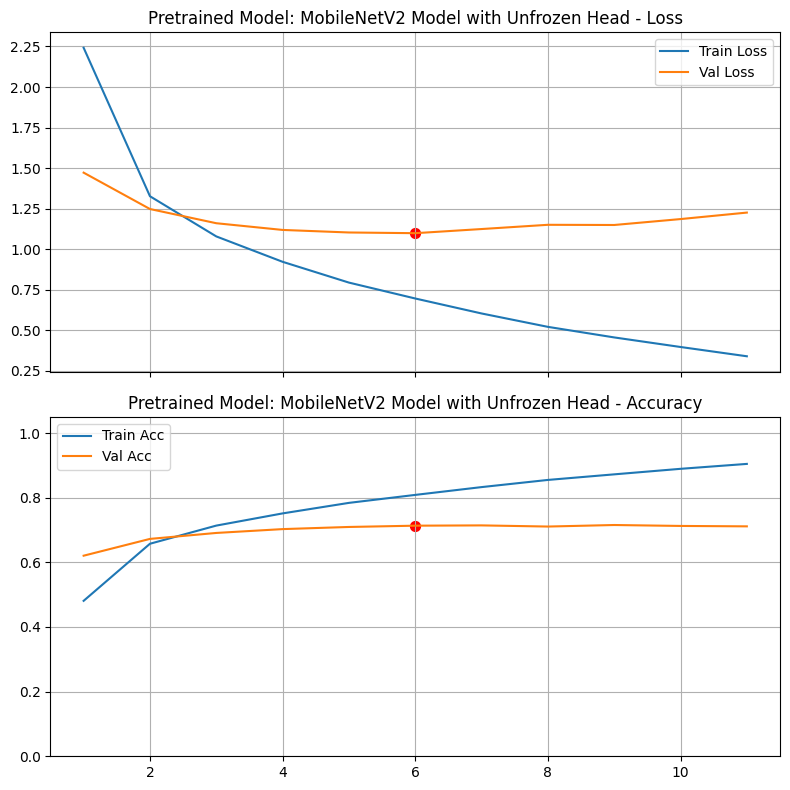

Final Train Acc: 0.9046, Val Acc: 0.7114
Val Acc @ Min Loss (epoch 6): 0.7135



Test Loss: 1.2137 | Test Acc: 0.7078
Best Val Acc: 0.7135 | ΔVal-Test: 0.0056
Execution Time: 00:17:51

 Training complete.


In [8]:
# ============================================================
# Final Model Definition and Training
# ============================================================

title = "Pretrained Model: MobileNetV2 Model with Unfrozen Head"

EPOCHS = 100
NUM_CLASSES = 101

class MobileNetV2Classifier(nn.Module):
    """
    MobileNetV2-based classifier with global average pooling.
    Equivalent to TensorFlow's MobileNetV2 with pooling='avg'
    """
    def __init__(self, num_classes=101, pretrained=True, trainable=True):
        super(MobileNetV2Classifier, self).__init__()
        
        # Load pretrained MobileNetV2
        #backbone = models.mobilenet_v2(pretrained=pretrained) # this is deprecated
        backbone = models.mobilenet_v2(weights='IMAGENET1K_V1' if pretrained else None)
        
        # Remove the classifier head (keep only features)
        self.features = backbone.features
        
        # Global average pooling (equivalent to pooling='avg')
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # New classifier head
        # MobileNetV2 has 1280 features after the last conv layer
        self.classifier = nn.Linear(1280, num_classes)
        
        # Set trainable status
        if not trainable:
            for param in self.features.parameters():
                param.requires_grad = False
        else:
            for param in self.features.parameters():
                param.requires_grad = True
    
    def forward(self, x):
        # Extract features
        x = self.features(x)
        
        # Global average pooling
        x = self.avgpool(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Classifier
        x = self.classifier(x)
        
        return x

# Create model with unfrozen backbone
model_unfrozen = MobileNetV2Classifier(
    num_classes=NUM_CLASSES,
    pretrained=True,
    trainable=True  # Entire model is trainable
)

print(f"Model created with {NUM_CLASSES} classes")
print(f"Total parameters: {sum(p.numel() for p in model_unfrozen.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_unfrozen.parameters() if p.requires_grad):,}")

# Learning rate schedule (exponential decay)
# PyTorch's ExponentialLR decays every epoch, so we adjust accordingly
steps_per_epoch = len(train_loader)
decay_epochs = 5  # Decay every 5 epochs
initial_lr = 5e-5
decay_rate = 0.90

# Custom training with exponential decay
def train_with_exp_decay(model, train_loader, val_loader, test_loader,
                         initial_lr=5e-5, decay_rate=0.90, decay_epochs=5,
                         epochs=100, patience=5, min_delta=5e-4):
    """
    Train with exponential learning rate decay
    """
    # Move model to device
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    
    # Exponential LR scheduler (decays every epoch by decay_rate)
    # To match TF's decay every N steps, we use gamma^(1/decay_epochs)
    gamma = decay_rate ** (1.0 / decay_epochs)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    # Mixed precision
    scaler = GradScaler('cuda')#changed, we have to tell it the device
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Print summary
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        
        # Check for improvement
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            print(f"Val Acc: {val_acc:.4f}")
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Plot curves
    plot_learning_curves(history, title, verbose=True)
    
    # Test evaluation
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    total_time = time.time() - start_time
    
    print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Best Val Acc: {best_val_acc:.4f} | ΔVal-Test: {abs(best_val_acc - test_acc):.4f}")
    print(f"Execution Time: {format_hms(total_time)}")
    
    # Save results
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    results[title] = {
        "val_acc_at_min_loss": best_val_acc,
        "min_val_epoch": best_epoch + 1,
        "test_acc": test_acc,
        "test_loss": test_loss,
    }
    
    return history, model

# Train the model
print(f"\n{title}\n")
hist2B, model_unfrozen = train_with_exp_decay(
    model_unfrozen,
    train_loader, val_loader, test_loader,
    initial_lr=initial_lr,
    decay_rate=decay_rate,
    decay_epochs=decay_epochs,
    epochs=EPOCHS,
    patience=5,
    min_delta=5e-4
)

print("\n Training complete.")

## A.3: Evaluation and Visualization

## Evaluation Strategies

### **Use of the Validation Split**
The validation split (10% of the dataset) was kept completely separate from both training and testing during the model development process. It was used to
- Monitor model performance epoch-by-epoch
- Tune hyperparameters such as learning rate schedule, early stopping patience, etc.
- Select the best-performing checkpoint based on validation accuracy and validation loss

No training updates were performed using validation data. Validation metrics were our northstar for model selection. We used the course-provided `train_and_test()` function.

---

### **Test Set Isolation**
The test set (10% of the dataset) was held out from the very beginning of the pipeline and not used during training and tuning operations. The test set was reserved strictly for final performance reporting to ensure an unbiased estimate of generalization to unseen data. All reported final metrics come from the test split. Again, we used the course-provided `train_and_test()` function for this.

---

### **Appropriate Metrics for Food-101**
Food-101 is a 101-class image classification dataset with many visually similar classes (e.g., ramen vs. pho, panna cotta vs. crème brûlée). Therefore, several metrics are appropriate:

#### **1. Accuracy (Top 1 Accuracy)**
- Standard accuracy metric  
- Measures how often the model’s highest-probability prediction matches the true class  
- Directly answers: “Did the model guess the correct label?”

#### **2. Per-Class Accuracy**
- Computes accuracy individually for each of the 101 food categories  
- Highlights which classes are learned well vs. poorly  
- Supports a detailed error and fairness analysis

#### **3. Top-K Accuracy (especially Top-5)**
- Measures whether the correct class appears in the model’s top-k predictions  
- Important for datasets with many similar classes  
- Answers: "Was the model at least close, even if its #1 guess was not correct?"

These metrics together provide a comprehensive picture of the model behavior and can assist in considering patterns in classification. In the case of a computer vision classification project like this, it is interesting to see how certain foods get mistaken for others that are similar in dish preparation or presentation.


## Evaluation: Top-k Accuracy (k=1, 5)

Top-k accuracy provides an additional perspective on model performance beyond standard Top-1 accuracy. Instead of requiring the model’s highest-probability prediction to be correct, Top-k accuracy considers a prediction correct if the true label appears anywhere within the model’s top k predicted classes. This is especially useful for large, fine-grained datasets where many classes share similar visual features. For us here it's food and dishes. The results below show how often the correct label appears as the top choice (Top-1) and within the top five predicted classes (Top-5).


In [9]:
# ============================================================
# Evaluation: Top-k Accuracy (k=1, 5)
# ============================================================

def calculate_topk_accuracy(model, dataloader, device, k_values=[1, 5]):
    """
    Calculate top-k accuracy for given k values
    
    Args:
        model: PyTorch model
        dataloader: DataLoader for evaluation
        device: torch device
        k_values: list of k values to compute (e.g., [1, 5])
    
    Returns:
        dict: Dictionary with top-k accuracies
    """
    model.eval()
    
    # Initialize counters for each k
    correct_k = {k: 0 for k in k_values}
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Calculating Top-K Accuracy'):
            images, labels = images.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(images)
            
            # Get top-k predictions for the largest k
            max_k = max(k_values)
            _, top_k_preds = outputs.topk(max_k, dim=1, largest=True, sorted=True)
            
            # Expand labels to compare with top-k predictions
            labels_expanded = labels.view(-1, 1).expand_as(top_k_preds)
            
            # Check correctness for each k
            for k in k_values:
                correct = top_k_preds[:, :k].eq(labels_expanded[:, :k]).any(dim=1)
                correct_k[k] += correct.sum().item()
            
            total += labels.size(0)
    
    # Calculate accuracies
    topk_accuracy = {f'top_{k}': correct_k[k] / total for k in k_values}
    
    return topk_accuracy

# Calculate top-1 and top-5 accuracy on test set
topk_results = calculate_topk_accuracy(model_unfrozen, test_loader, device, k_values=[1, 5])

print(f"Top-1 Accuracy: {topk_results['top_1']:.4f}")
print(f"Top-5 Accuracy: {topk_results['top_5']:.4f}")

Calculating Top-K Accuracy: 100%|██████████| 316/316 [00:08<00:00, 35.31it/s]

Top-1 Accuracy: 0.7078
Top-5 Accuracy: 0.9021


## Evaluation: Normalized (0-1) Confusion Matrix Heatmap

The normalized confusion matrix heatmap allows us to visualize the accuracy of each class. We see a strong diagonal line, showing the model correctly predicts most classes in the Food-101 test set. However, misclassifications are harder to visualize here than the raw log-normalized heatmap in our following cell.


Generating predictions: 100%|██████████| 316/316 [00:11<00:00, 27.41it/s]


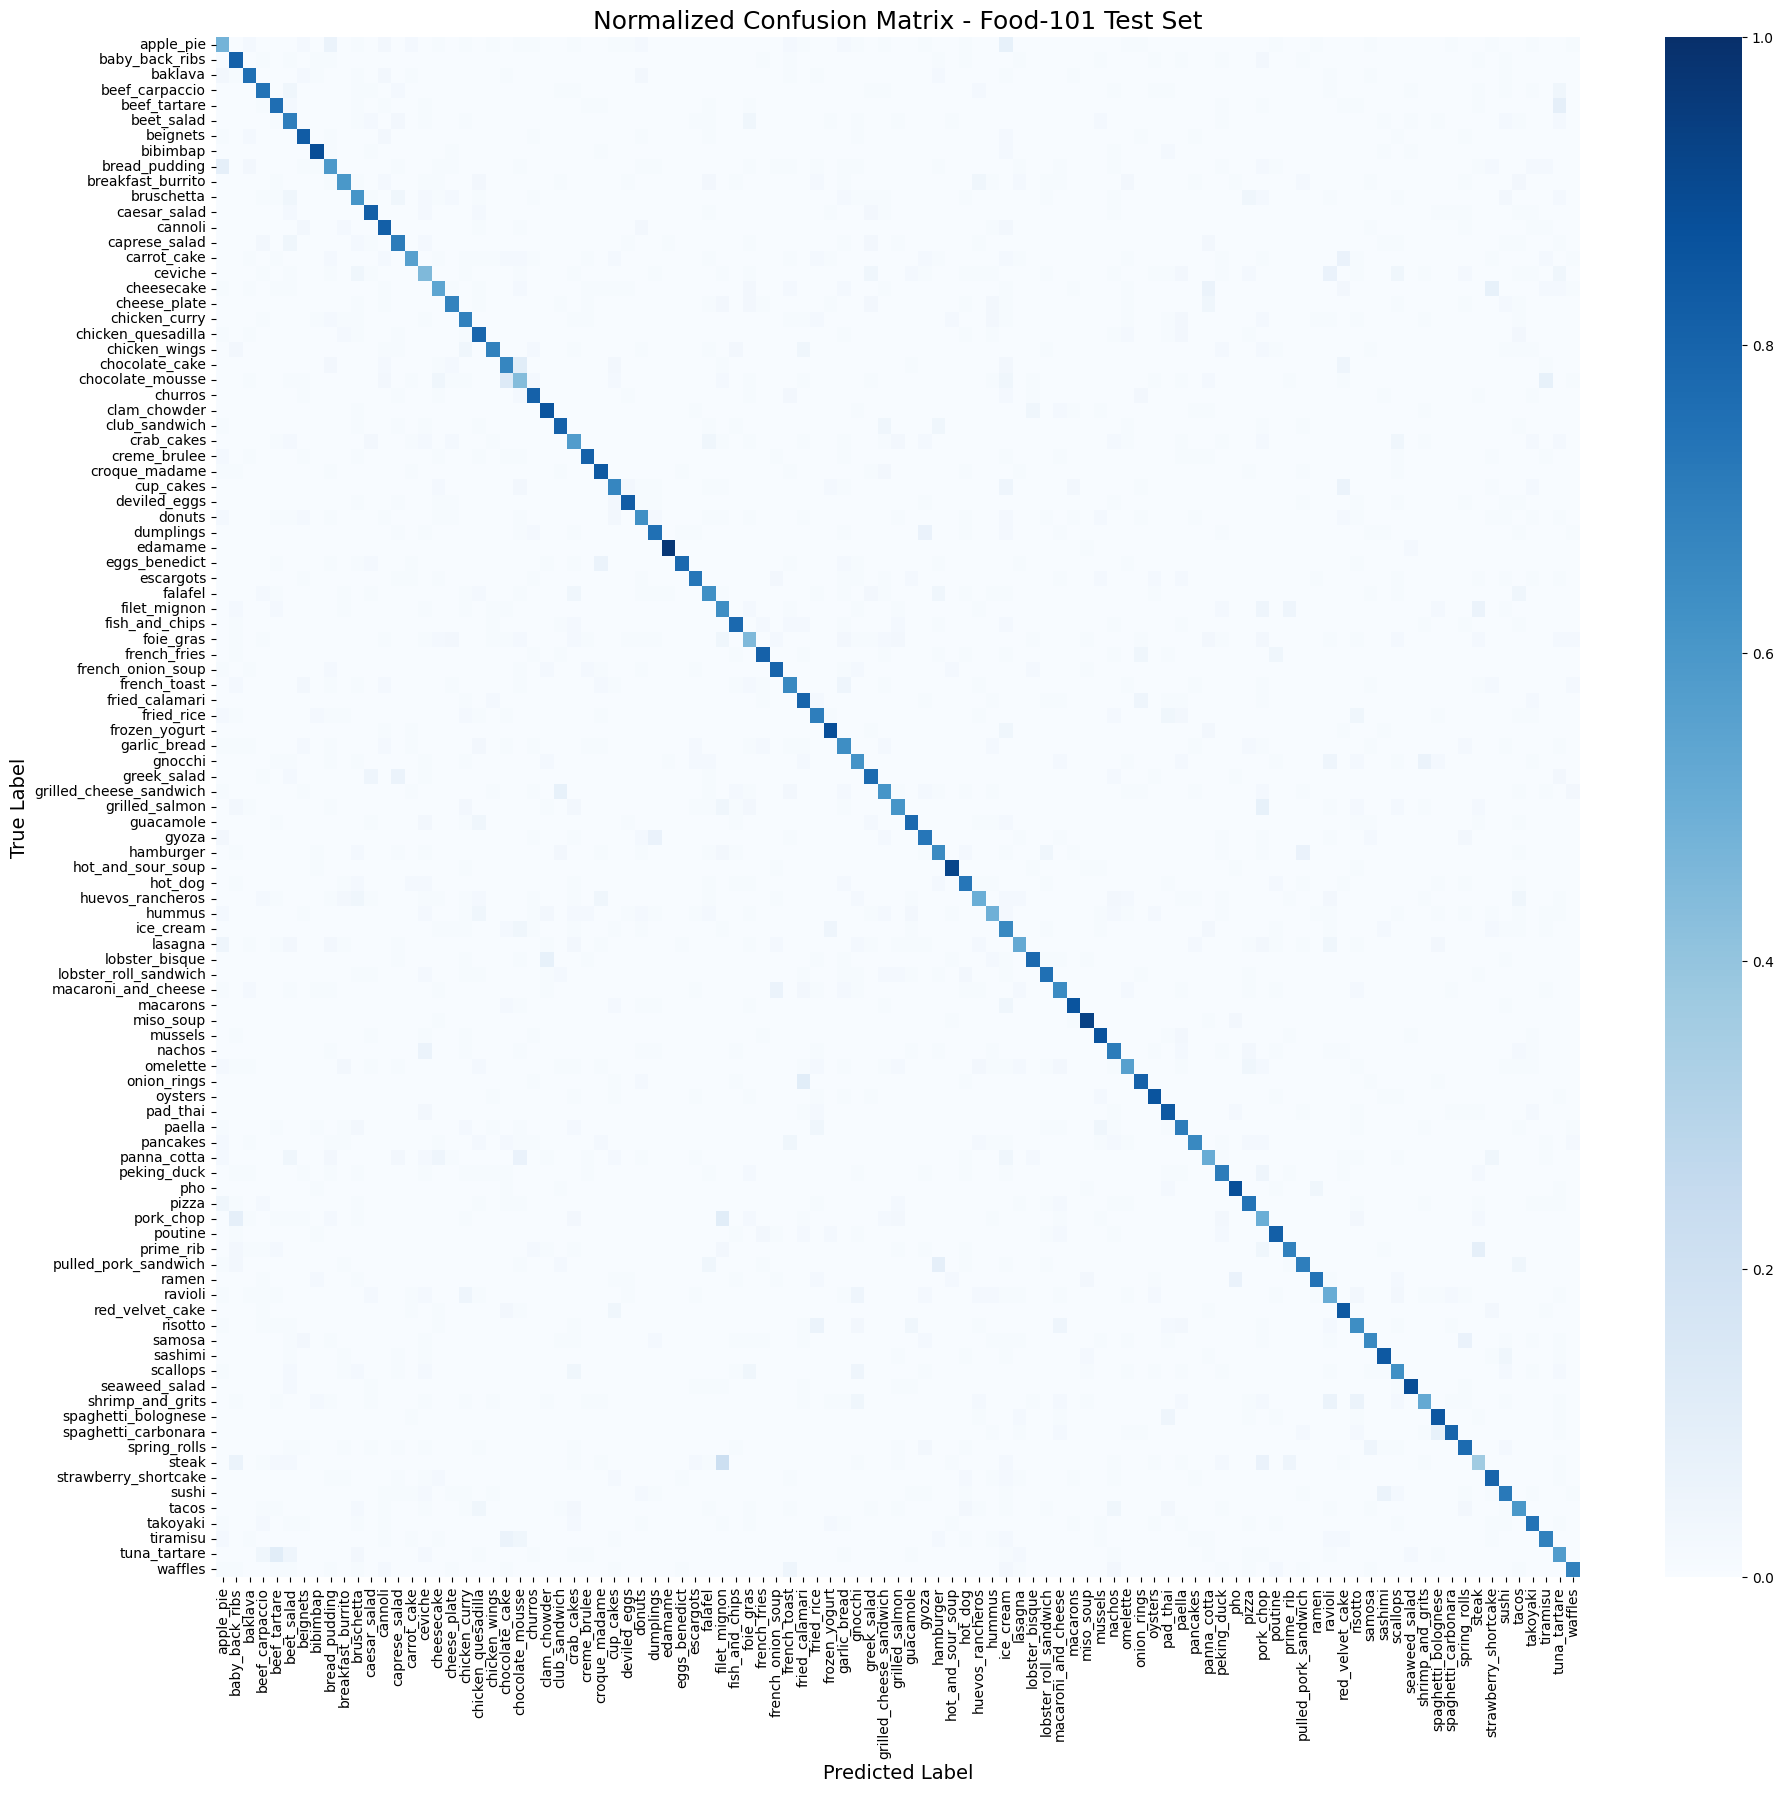

In [10]:
# ============================================================
#  Evaluation: Normalized Confusion Matrix
# ============================================================

# Get label names
label_names = food_all.features["label"].names

# Build y_true and y_pred
y_true = []
y_pred = []

model_unfrozen.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Generating predictions'):
        images = images.to(device)
        
        # Get predictions
        outputs = model_unfrozen(images)
        preds = outputs.argmax(dim=1)
        
        # Collect true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Normalized confusion matrix (values 0-1 per row)
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plot
plt.figure(figsize=(22, 20))
sns.heatmap(
    cm,
    cmap="Blues",
    vmin=0.0,  # ensures scale starts at 0
    vmax=1.0,  # ensures scale ends at 1
    cbar=True,
    xticklabels=label_names,
    yticklabels=label_names
)

plt.title("Normalized Confusion Matrix - Food-101 Test Set", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Evaluation: Raw Log-Normalized Confusion Matrix Heatmap

The raw log-normalized confusion matrix heatmap allows us to visualize misclassifications better. Althougt the main diagonal line is more homogenous and less useful, the outlying areas yield better visual information for the less successful classifications.  

Generating predictions: 100%|██████████| 316/316 [00:08<00:00, 36.17it/s]


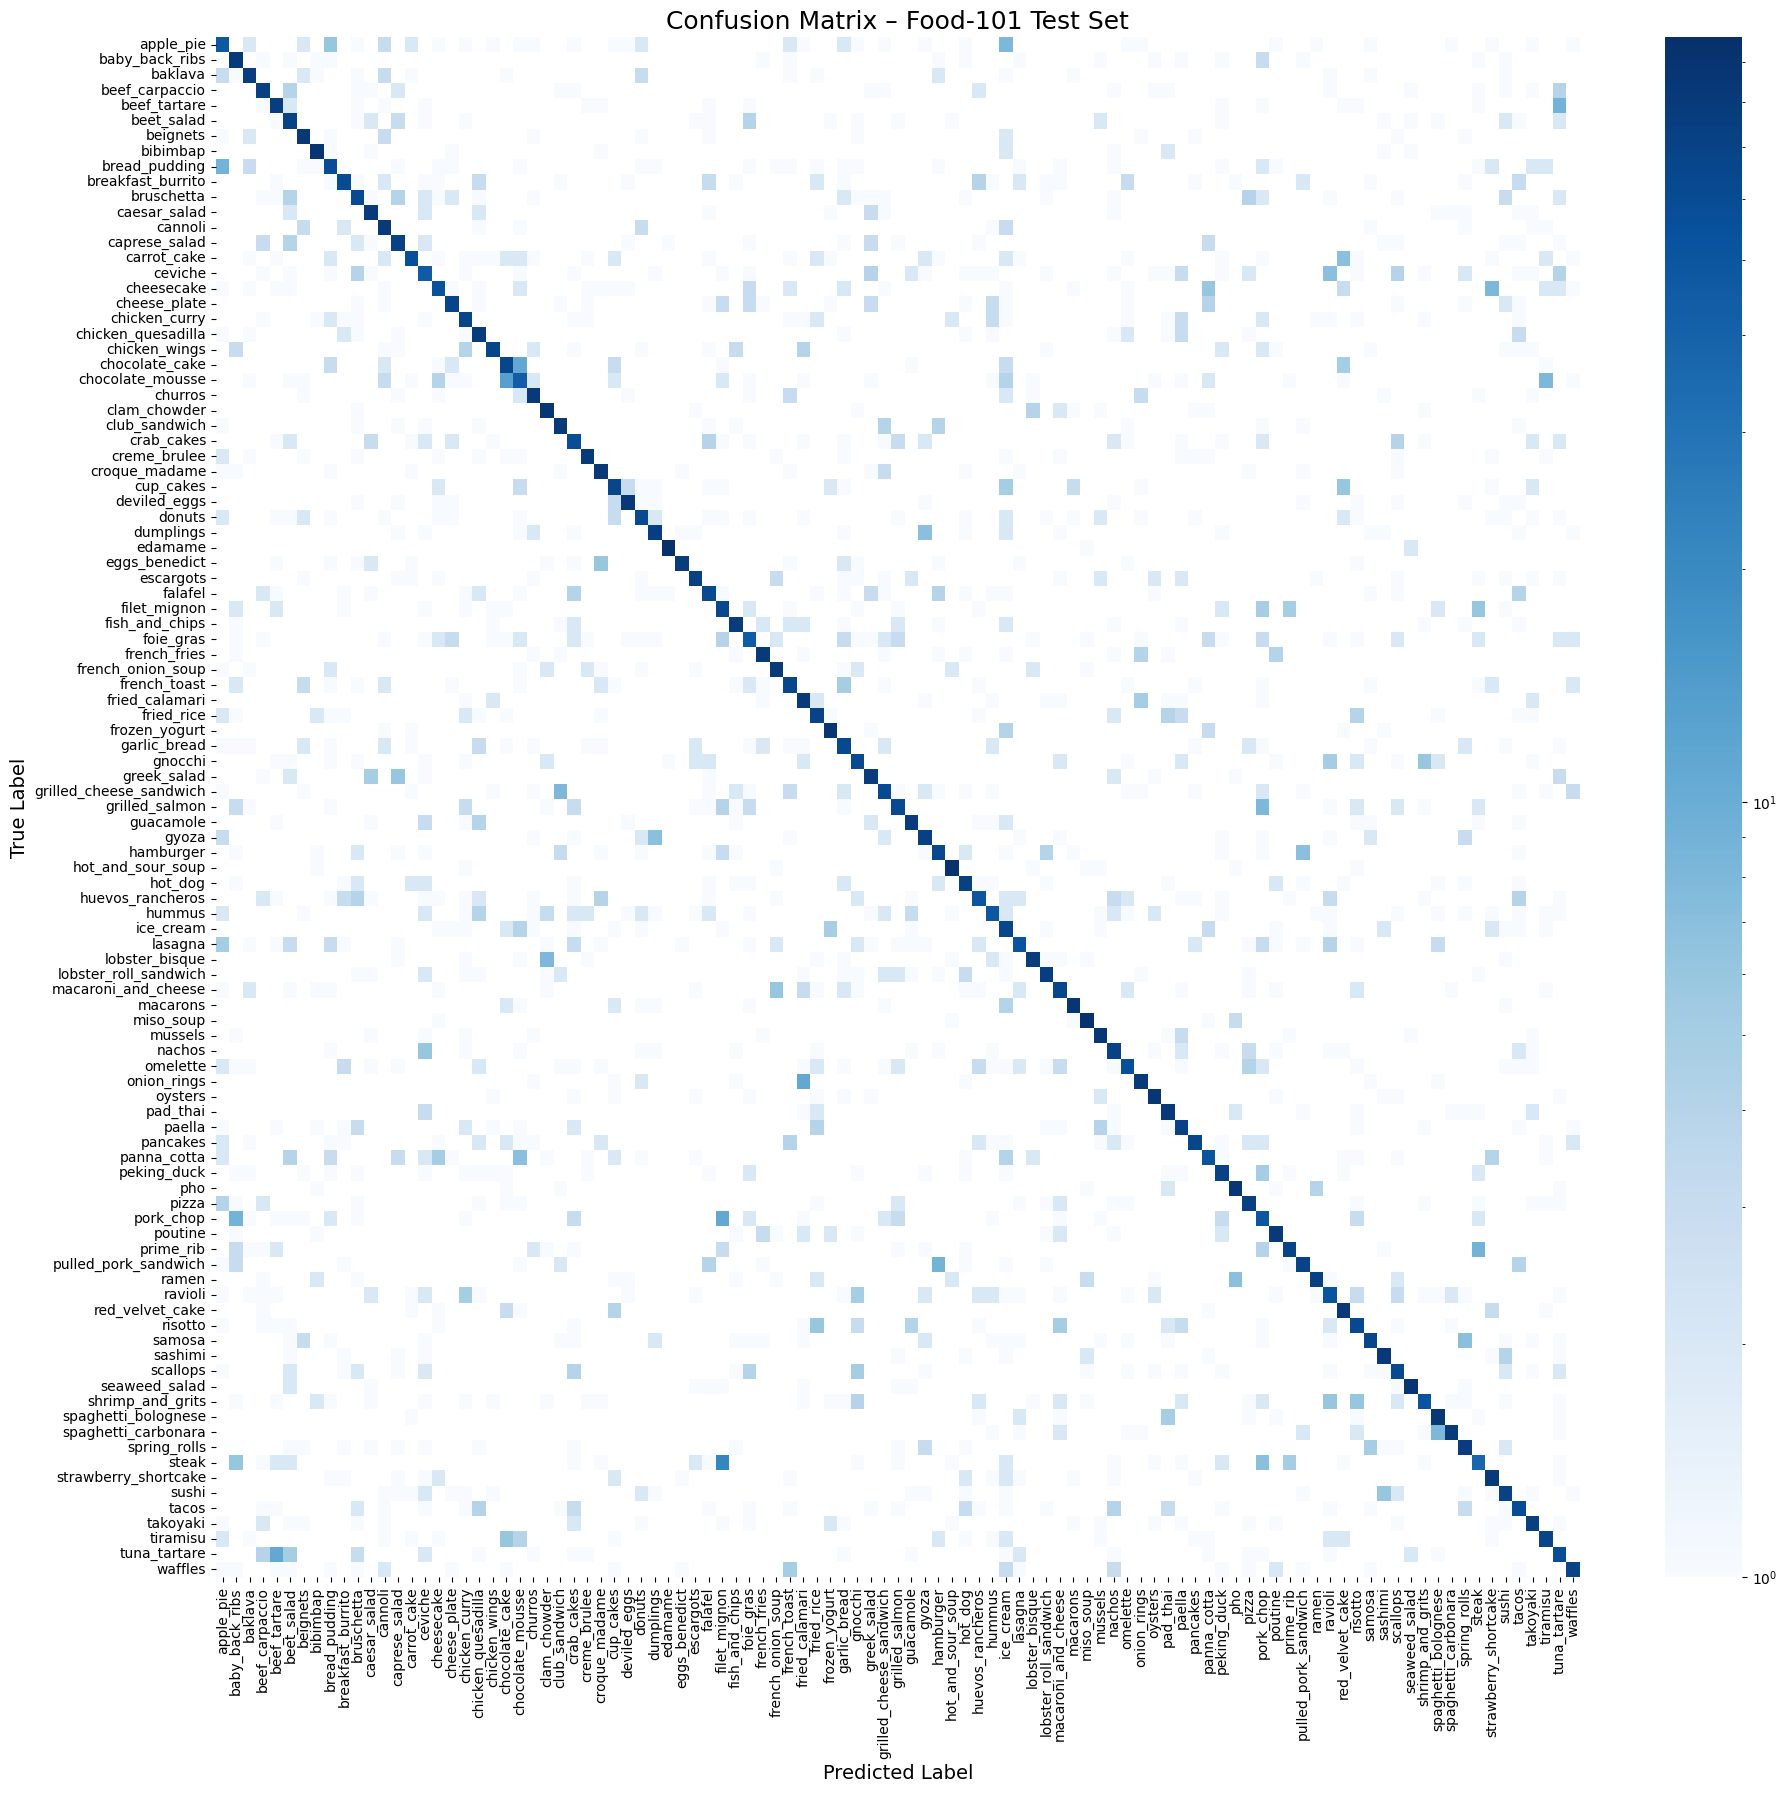

In [11]:
# ============================================================
#  Evaluation: Raw log-normalized Confusion Matrix
# ============================================================

# Get label names
label_names = load_dataset("food101")["train"].features["label"].names


# Set up true vs predict
y_true = []
y_pred = []


model_unfrozen.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Generating predictions'):
        images = images.to(device)
        
        # Get predictions
        outputs = model_unfrozen(images)
        preds = outputs.argmax(dim=1)
        
        # Collect true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Set up the plot
plt.figure(figsize=(22, 20))
sns.heatmap(
    cm,
    cmap="Blues",
    norm=plt.cm.colors.LogNorm(),
    cbar=True,
    xticklabels=label_names,
    yticklabels=label_names
)

# Do the plot
plt.title("Confusion Matrix – Food-101 Test Set", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Evaluation: Per-Class Precision, Recall, and F1 Classification Report

Using precision, recall, and F1 scores we can see how well the model distinguishes each individual food category. We can see these specific strengths and weaknesses across all classes. Precision shows how often a predicted class is correct, recall measures how often the model successfully identifies each true class, and F1 balances both measures. This report helps us to zoom in on the model's performance of each class.

In [12]:
# ============================================================
# Evaluation: Precision, Recall, and F1 by Class
# ============================================================
# Get the label names
label_names = load_dataset("food101")["train"].features["label"].names

# Get classification
print("\nClassification Report (Labeled):")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))


Classification Report (Labeled):
                         precision    recall  f1-score   support

              apple_pie     0.4615    0.4800    0.4706       100
         baby_back_ribs     0.6328    0.8100    0.7105       100
                baklava     0.7500    0.7500    0.7500       100
         beef_carpaccio     0.7184    0.7400    0.7291       100
           beef_tartare     0.6726    0.7600    0.7136       100
             beet_salad     0.5738    0.7000    0.6306       100
               beignets     0.7477    0.8300    0.7867       100
               bibimbap     0.8476    0.8900    0.8683       100
          bread_pudding     0.5673    0.5900    0.5784       100
      breakfast_burrito     0.7229    0.6000    0.6557       100
             bruschetta     0.5648    0.6100    0.5865       100
           caesar_salad     0.7455    0.8200    0.7810       100
                cannoli     0.7009    0.8200    0.7558       100
          caprese_salad     0.6698    0.7100    0.6893 

## Evaluation: Top 20 Classes by Per-Class Accuracy

This report allows us to scan the classes that the model predicted best. We see that certain foods with distinct shapes (edamame or macarons) or plate shape (soups and salads) dominate this list.

In [13]:
# ============================================================
# Evaluation: Top 20 Classes by Per-Class Accuracy
# ============================================================

# Make the data container
per_class_acc = {}

# Compute per-class accuracy
for i, label in enumerate(label_names):
    correct = cm[i, i]
    total = cm[i].sum()
    acc = correct / total if total > 0 else 0.0
    per_class_acc[label] = acc

df_acc = pd.DataFrame.from_dict(per_class_acc, orient="index", columns=["accuracy"])
df_acc_sorted = df_acc.sort_values(by="accuracy", ascending=False)

# Display top 20
print("\nTop 20 Classes by Accuracy:")
print(df_acc_sorted.head(20))


Top 20 Classes by Accuracy:
                     accuracy
edamame                  0.97
miso_soup                0.93
hot_and_sour_soup        0.92
bibimbap                 0.89
seaweed_salad            0.89
frozen_yogurt            0.88
pho                      0.88
mussels                  0.87
macarons                 0.86
oysters                  0.86
clam_chowder             0.86
spaghetti_bolognese      0.85
red_velvet_cake          0.84
pad_thai                 0.84
sashimi                  0.84
croque_madame            0.84
deviled_eggs             0.83
beignets                 0.83
caesar_salad             0.82
cannoli                  0.82


## Evaluation: Bottom 20 Classes by Per-Class Accuracy

This report allows us to see the food classes that our model performed worse on. We can see some foods that can be easily misclassified, like chops, steaks, and also desserts like chocolate mousse and ice cream. We review this more deeply in the next cell.

In [14]:
# ============================================================
# Evaluation: Bottom 20 Classes by Per-Class Accuracy
# ============================================================

# Display bottom 20
print("\nBottom 20 Classes by Accuracy:")
print(df_acc_sorted.tail(20))



Bottom 20 Classes by Accuracy:
                   accuracy
tacos                  0.60
breakfast_burrito      0.60
bread_pudding          0.59
crab_cakes             0.58
tuna_tartare           0.58
carrot_cake            0.56
omelette               0.56
cheesecake             0.54
shrimp_and_grits       0.52
lasagna                0.52
ravioli                0.51
panna_cotta            0.51
pork_chop              0.50
huevos_rancheros       0.50
hummus                 0.49
apple_pie              0.48
foie_gras              0.45
ceviche                0.45
chocolate_mousse       0.44
steak                  0.37


## Evaluation: Top 20 Misclassification Pairs

To better understand where the model struggles, we examined the most frequent misclassification pairs. These represent the true labels that are most often confused with specific predicted labels. Looking at the misclassifications we see  visually similar or ambiguous food categories, revealing systematic weaknesses that may not be obvious from our metrics. The table below lists the 20 most common true→predicted label errors in the test set.


In [15]:
# ============================================================
# Evaluation: Top 20 Most Frequent Misclassifications
# ============================================================

# Get top misclassifications
errors = y_true != y_pred
pairs, counts = np.unique(
    list(zip(y_true[errors], y_pred[errors])),
    axis=0, return_counts=True
)

sorted_idx = np.argsort(counts)[::-1]
top_k = 20

print("\nTop Misclassifications (true_label_name → predicted_label_name):")
for idx in sorted_idx[:top_k]:
    t, p = pairs[idx]
    print(f"{label_names[t]:25s} → {label_names[p]:25s}   Count: {counts[idx]}")


Top Misclassifications (true_label_name → predicted_label_name):
steak                     → filet_mignon                Count: 22
chocolate_mousse          → chocolate_cake              Count: 13
tuna_tartare              → beef_tartare                Count: 11
chocolate_cake            → chocolate_mousse            Count: 11
onion_rings               → fried_calamari              Count: 11
pork_chop                 → filet_mignon                Count: 11
prime_rib                 → steak                       Count: 9
pulled_pork_sandwich      → hamburger                   Count: 9
pork_chop                 → baby_back_ribs              Count: 9
bread_pudding             → apple_pie                   Count: 9
beef_tartare              → tuna_tartare                Count: 9
apple_pie                 → ice_cream                   Count: 8
spaghetti_carbonara       → spaghetti_bolognese         Count: 8
chocolate_mousse          → tiramisu                    Count: 8
grilled_cheese_san

## Evaluation: Final Test and Validation Metrics

This is a summary of the final test and validation metrics.

In [17]:
# ============================================================
# Evaluation: Top 20 Most Frequent Misclassifications
# ============================================================

if results:
    df_results = pd.DataFrame([
        {
            "Model": k,
            "Val_Acc_at_Min_Loss": v.get("val_acc_at_min_loss"),
            "Best_Epoch": v.get("min_val_epoch"),
            "Test_Acc": v.get("test_acc"),
            "Test_Loss": v.get("test_loss"),
        }
        for k, v in results.items()
    ]).sort_values("Val_Acc_at_Min_Loss", ascending=False)

    display(df_results.style.format({
        "Val_Acc_at_Min_Loss": "{:.4f}",
        "Test_Acc": "{:.4f}",
        "Test_Loss": "{:.4f}"
    }))
else:
    print("No models logged yet — make sure track_results=True in plot_learning_curves().")

,Model,Val_Acc_at_Min_Loss,Best_Epoch,Test_Acc,Test_Loss
0,Pretrained Model: MobileNetV2 Model with Unfrozen Head,0.7135,6,0.7078,1.2137
